# Demo Feeder Concept
This notebook shows a basics of a feeder concept. This scenario has two vessels:
* a *vessel* for the transport of material
* an *installer*, receiving the material and installing it.
Thus, we also need two processes - one for each vessel. In this process the hand over of the material is done from the *vessel* to the *installer*.

In [1]:
import datetime, time
import simpy

import shapely.geometry


# package(s) for data handling
import pandas as pd
import numpy as np

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

import uuid

# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)
registry = {}
keep_resources = {}

## Definition of Sites

In [2]:
# The generic site class
Site = type(
    "Site",
    (
        core.Identifiable,  # Give it a name
        core.Log,  # Allow logging of all discrete events
        core.Locatable,  # Add coordinates to extract distance information and visualize
        core.HasMultiContainer,  # Add information on the material available at the site
        core.HasResource,
    ),  # Add information on serving equipment
    {},
)  # The dictionary is empty because the site type is generic

# Information on the extraction site - the "from site" - the "win locatie"
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)  # lon, lat

data_from_site = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "Winlocatie",  # The name of the site
    "ID": str(uuid.uuid4()),  # For logging purposes
    "geometry": location_from_site,  # The coordinates of the project site
    "store_capacity": 4,
    "initials": [
        {"id": "MP", "level": 5, "capacity": 10},
        {"id": "TP", "level": 5, "capacity": 10},
    ],
}  # The actual volume of the site

# Information on the dumping site - the "to site" - the "dump locatie"
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)  # lon, lat

data_to_site = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "Dumplocatie",  # The name of the site
    "ID": str(uuid.uuid4()),  # For logging purposes
    "geometry": location_to_site,  # The coordinates of the project site
    "store_capacity": 4,
    "initials": [
        {"id": "MP", "level": 0, "capacity": 5},
        {"id": "TP", "level": 0, "capacity": 5},
    ],
}  # The actual volume of the site (empty of course)

# The two objects used for the simulation
from_site = Site(**data_from_site)
to_site = Site(**data_to_site)


## Definition of Vessels

In [3]:
# The generic class for an object that can move and transport (a TSHD for example)
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,  # Give it a name
        core.Log,  # Allow logging of all discrete events
        core.MultiContainerDependentMovable,  # A moving container, so capacity and location
        core.Processor,  # Allow for loading and unloading
        core.HasResource,  # Add information on serving equipment
        
        core.LoadingFunction,  # Add a loading function
        core.UnloadingFunction,  # Add an unloading function
        # SiteRegistry,
    ),
    {"key": "MultiStoreHopper"},
)

# print(SiteRegistry.inspect("MultiStoreHopper"))
# For more realistic simulation you might want to have speed dependent on the volume carried by the vessel
def compute_v_provider(v_empty, v_full):
    return lambda x: 10


# TSHD variables
data_vessel = {
    "env": my_env,  # The simpy environment
    "name": "Vessel 01",  # Name
    "ID": str(uuid.uuid4()),  # For logging purposes
    "geometry": location_from_site,  # It starts at the "from site"
    "loading_rate": 1,  # Loading rate
    "unloading_rate": 1,  # Unloading rate
    "store_capacity": 4,
    "initials": [
        {"id": "MP", "level": 0, "capacity": 2},
        {"id": "TP", "level": 0, "capacity": 2},
    ],  # Capacity of the hopper - "Beunvolume"
    "compute_v": compute_v_provider(5, 4.5),  # Variable speed
}
vessel = TransportProcessingResource(**data_vessel)


data_installer = {
    "env": my_env,  # The simpy environment
    "name": "Installer",  # Name
    "ID": str(uuid.uuid4()),  # For logging purposes
    "geometry": location_from_site,  # It starts at the "from site"
    "loading_rate": 1,  # Loading rate
    "unloading_rate": 1,  # Unloading rate
    "store_capacity": 4,
    "initials": [
        {"id": "MP", "level": 0, "capacity": 1},
        {"id": "TP", "level": 0, "capacity": 1},
    ],  # Capacity of the hopper - "Beunvolume"
    "compute_v": compute_v_provider(5, 4.5),  # Variable speed
}
installer = TransportProcessingResource(**data_installer)

## Definition of Vessel process

In [4]:
# definition of vessel main cycle
def vessel_process(vessel):
    single_run = []
    move_activity_to_harbor_data = {
        "env": my_env,  # The simpy environment defined in the first cel
        "name": "sailing empty",  # We are moving soil
        "ID": str(uuid.uuid4()),  # For logging purposes
        "registry": registry,
        "mover": vessel,
        "destination": from_site,
        "postpone_start": True,
    }
    single_run.append(model.MoveActivity(**move_activity_to_harbor_data))
    
    shift_amount_loading_data = {
        "env": my_env,  # The simpy environment defined in the first cel
        "name": "Load MP",  # We are moving soil
        "ID": str(uuid.uuid4()),  # For logging purposes
        "registry": registry,
        "processor": vessel,
        "origin": from_site,
        "destination": vessel,
        "amount": 1,
        "duration": 120,
        "id_": "MP",
        "postpone_start": True,
    }
    single_run.append(model.ShiftAmountActivity(**shift_amount_loading_data))
    
    move_activity_to_site_data = {
        "env": my_env,  # The simpy environment defined in the first cel
        "name": "sailing filled",  # We are moving soil
        "ID": str(uuid.uuid4()),  # For logging purposes
        "registry": registry,
        "mover": vessel,
        "destination": to_site,
        "postpone_start": True,
    }
    single_run.append(model.MoveActivity(**move_activity_to_site_data))
    
    shift_amount_unloading_data = {
        "env": my_env,  # The simpy environment defined in the first cel
        "name": "Transfer MP",  # We are moving soil
        "ID": str(uuid.uuid4()),  # For logging purposes
        "registry": registry,
        "processor": installer,
        "origin": vessel,
        "destination": installer,
        "amount": 1,
        "duration": 120,
        "id_": "MP",
        "postpone_start": True,
        "start_event": [{"type":"activity", "name": "Sail transit" , "state":"done"}],
    }
    single_run.append(model.ShiftAmountActivity(**shift_amount_unloading_data))
    
    sequential_activity_data3 = {
        "env": my_env,
        "name": "Single run process",
        "ID": str(uuid.uuid4()),  # For logging purposes
        "registry": registry,
        "sub_processes": single_run,
        "postpone_start": True,
    }
    activity = model.SequentialActivity(**sequential_activity_data3)
    
    while_data = {
        "env": my_env,  # The simpy environment defined in the first cel
        "name": "single run while",  # We are moving soil
        "ID": str(uuid.uuid4()),  # For logging purposes
        "registry": registry,
        "sub_processes": [activity],
        "condition_event": [{"type":"container", "concept": from_site, "state":"empty", "id_":"MP"}],
        "postpone_start": False,
    }
    while_activity = model.WhileActivity(**while_data)
    return while_activity


## Definition of Installer process

In [5]:
# installer process
#
installer_run = []
move_activity_to_site_data = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "sailing empty",  # We are moving soil
    "ID": str(uuid.uuid4()),  # For logging purposes
    "registry": registry,
    "mover": installer,
    "destination": to_site,
    "postpone_start": True,
}
installer_run.append(model.MoveActivity(**move_activity_to_site_data))

installer_run2 = []
basic_activity_data= {"env"  : my_env,
                      "name" : "Sail transit",
                      "registry": registry,
                      "ID":str(uuid.uuid4()),  # For logging purposes
                      "duration" : 30,
                      "additional_logs": [installer],
                      "postpone_start": True,
                      }
installer_run2.append(model.BasicActivity(**basic_activity_data))

basic_activity_data33= {"env"  : my_env,
                      "name" : "Prepare installation",
                      "registry": registry,
                      "ID":str(uuid.uuid4()),  # For logging purposes
                      "duration" : 60,
                      "additional_logs": [installer],
                      "postpone_start": True,
                      "start_event": [{"type":"activity", "name": "Single run process" , "state":"done"}],
                      }
installer_run2.append(model.BasicActivity(**basic_activity_data33))

shift_amount_unloading_data2 = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "Install MP",  # We are moving soil
    "ID": str(uuid.uuid4()),  # For logging purposes
    "registry": registry,
    "processor": installer,
    "origin": installer,
    "destination": to_site,
    "amount": 1,
    "duration": 120,
    "id_": "MP",
    "postpone_start": True,
}
installer_run2.append(model.ShiftAmountActivity(**shift_amount_unloading_data2))

sequential_activity_data3 = {
    "env": my_env,
    "name": "Installer run process 2",
    "ID": str(uuid.uuid4()),  # For logging purposes
    "registry": registry,
    "sub_processes": installer_run2,
    "postpone_start": True,
}
activity = model.SequentialActivity(**sequential_activity_data3)

while_data = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "installer run while",  # We are moving soil
    "ID": str(uuid.uuid4()),  # For logging purposes
    "registry": registry,
    "sub_processes": [activity],
    "condition_event": [{"type":"container", "concept": to_site, "state":"full", "id_":"MP"}],
    "postpone_start": True,
}
installer_run.append(model.WhileActivity(**while_data))

sequential_activity_data4 = {
    "env": my_env,
    "name": "Installer run process",
    "ID": str(uuid.uuid4()),  # For logging purposes
    "registry": registry,
    "sub_processes": installer_run,
    "postpone_start": False,
}
installer_proc = model.SequentialActivity(**sequential_activity_data4)

## instantiate vessel process
vessel_proc = vessel_process(vessel)


In [6]:
my_env.run()


In [7]:
 plot.vessel_planning([vessel, installer, from_site, to_site])

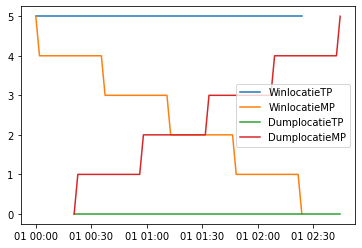

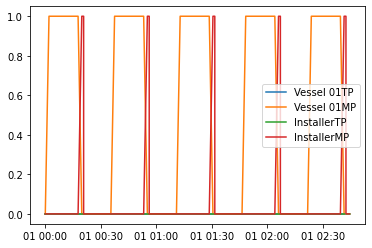

In [8]:
fig = plot.get_step_chart([from_site, to_site])
fig = plot.get_step_chart([vessel, installer])